In [1]:
# https://www.pymc-labs.io/blog-posts/bayesian-vector-autoregression/

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib.colors import ColorConverter
import jdatetime
import graphviz
az.style.use("arviz-darkgrid")
seed = sum(map(ord, "PyMC LABS - BVAR"))
rng = np.random.default_rng(seed=seed)

In [113]:
def simulate_ar(intercept, coef1, coef2, noise=1, *, warmup=10, steps=200):   
    # We sample some extra warmup steps, to let the AR process stabilize
    draws = np.zeros(warmup+steps)
    # Initialize first draws at intercept
    draws[:2] = intercept
    for step in range(2, warmup+steps):
        draws[step] = (
            intercept 
            + coef1 * draws[step-1]
            + coef2 * draws[step-2]
            + rng.normal(0, noise)
        )
    # Discard the warmup draws
    return draws[warmup:]

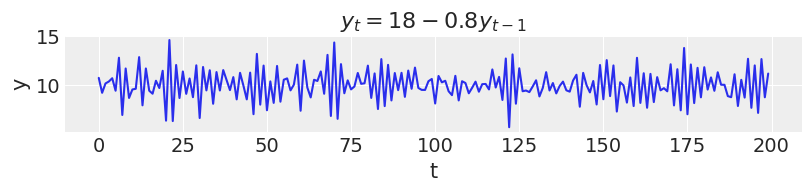

In [114]:
ar1 = simulate_ar(18, -0.8, 0)

_, ax = plt.subplots(figsize=(8, 1.8))
ax.plot(ar1)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("$y_t = 18 - 0.8y_{t-1}$");

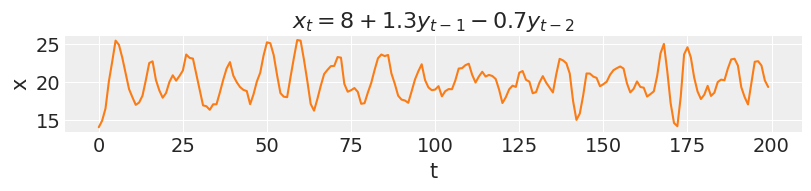

In [115]:
ar2 = simulate_ar(8, 1.3, -0.7)

_, ax = plt.subplots(figsize=(8, 1.8))
ax.plot(ar2, color="C1")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("$x_t = 8 + 1.3y_{t-1} - 0.7y_{t-2}$");

In [116]:
def simulate_var(intercepts, coefs_yy, coefs_xy, coefs_xx, coefs_yx, noises=(1, 1), *, warmup=100, steps=200):
    draws_y = np.zeros(warmup+steps)
    draws_x = np.zeros(warmup+steps)
    draws_y[:2] = intercepts[0]
    draws_x[:2] = intercepts[1]
    for step in range(2, warmup+steps):
        draws_y[step] = (
            intercepts[0]
            + coefs_yy[0] * draws_y[step-1]
            + coefs_yy[1] * draws_y[step-2]
            + coefs_xy[0] * draws_x[step-1]
            + coefs_xy[1] * draws_x[step-2]
            + rng.normal(0, noises[0])
        )
        draws_x[step] = (
            intercepts[1]
            + coefs_xx[0] * draws_x[step-1]
            + coefs_xx[1] * draws_x[step-2]
            + coefs_yx[0] * draws_y[step-1]
            + coefs_yx[1] * draws_y[step-2]
            + rng.normal(0, noises[1])
        )
    return draws_y[warmup:], draws_x[warmup:]

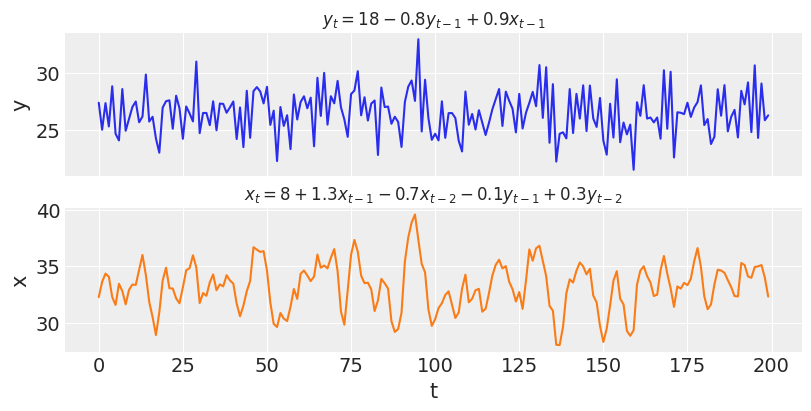

In [117]:
var_y, var_x = simulate_var(
    intercepts=(18, 8),
    coefs_yy=(-0.8, 0),
    coefs_xy=(0.9, 0),
    coefs_xx=(1.3, -0.7),
    coefs_yx=(-0.1, 0.3),
)

_, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(var_y)
ax[0].set_title("$y_t = 18 - 0.8y_{t-1} + 0.9x_{t-1}$", fontsize=12)
ax[0].set_ylabel("y")

ax[1].plot(var_x, color="C1")
ax[1].set_title("$x_t = 8 + 1.3x_{t-1} - 0.7x_{t-2} - 0.1y_{t-1} + 0.3y_{t-2}$", fontsize=12)
ax[1].set_ylabel("x")
ax[1].set_xlabel("t");

## Beysian VAR for US data

In [118]:
# 100% HDI that this link will go stale in the next 6 months = (0, 1)
link = "https://www.princeton.edu/~mwatson/Stock-Watson_3u/Students/EE_Datasets/us_macro_quarterly.xlsx"
df = pd.read_excel(link, storage_options={'User-Agent': 'Mozilla/5.0'}, index_col=0)

df.index = pd.to_datetime(
    df.index
    .str.replace(":01", "-01-01")
    .str.replace(":02", "-04-01")
    .str.replace(":03", "-07-01")
    .str.replace(":04", "-10-01")
)

df.rename(columns={"GDPC96": "GDP"}, inplace=True)

df = df[["GDP", "GS10", "TB3MS"]]
# This is an approximation of the annual growth rate
df["GDPGrowth"] = 400 * np.log(df["GDP"] / df["GDP"].shift())
# Term spread as the difference between 10-year and 3-month U.S. Treasury bonds
df["TSpread"] = df["GS10"] - df["TB3MS"] 
df = df["1981":]
df

c:\Users\abyo0503\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,GDP,GS10,TB3MS,GDPGrowth,TSpread
1981-01-01,6628.634,12.960000,14.390000,8.200270,-1.430000
1981-04-01,6580.199,13.750000,14.906667,-2.933505,-1.156667
1981-07-01,6655.692,14.846667,15.053333,4.562976,-0.206667
1981-10-01,6578.035,14.086667,11.750000,-4.694544,2.336667
1982-01-01,6468.003,14.293333,12.813333,-6.747465,1.480000
...,...,...,...,...,...
2012-10-01,15539.628,1.706667,0.086667,0.145281,1.620000
2013-01-01,15583.948,1.950000,0.086667,1.139201,1.863333
2013-04-01,15679.677,1.996667,0.050000,2.449602,1.946667
2013-07-01,15839.347,2.710000,0.033333,4.052698,2.676667


In [119]:
data = df[["GDPGrowth", "TSpread"]][:-10]
test_data = df[["GDPGrowth", "TSpread"]][-10:]
data.shape, test_data.shape

((122, 2), (10, 2))

In [120]:
colors = ("C0", "C1")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
}

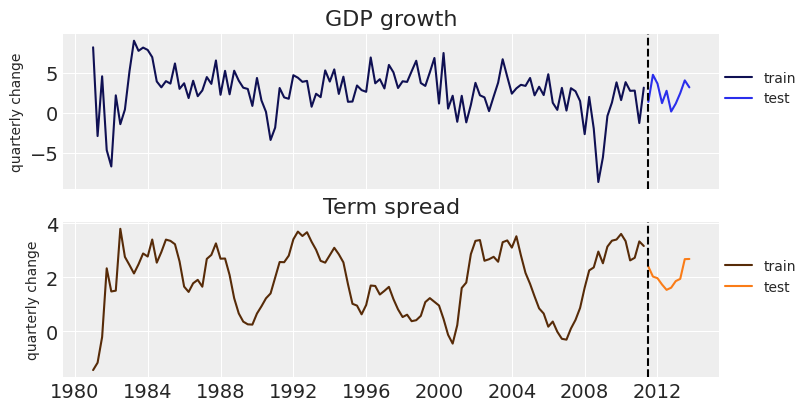

In [121]:
_, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(data["GDPGrowth"], color=dark["C0"], label="train")
ax[0].plot(test_data["GDPGrowth"], color="C0", label="test")
ax[0].set_ylabel("quarterly change", fontsize=10)
ax[0].set_title("GDP growth")

ax[1].plot(data["TSpread"], color=dark["C1"], label="train")
ax[1].plot(test_data["TSpread"], color="C1", label="test")
ax[1].set_ylabel("quarterly change", fontsize=10)
ax[1].set_title("Term spread");

for axi in ax:
    axi.axvline(df.index[-10], ls="--", color="k")
    axi.legend(loc=(1, 0.5), fontsize=10)

In [123]:
lags = 2

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": ("GDPGrowth", "TSpread"),
    "cross_vars": ("GDPGrowth", "TSpread"),
    "time": range(len(data) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_GDPGrowth = pm.math.sum([
        pm.math.sum(lag_coefs[i, 0] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)        
    ar_TSpread = pm.math.sum([
        pm.math.sum(lag_coefs[i, 1] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)   

    # Stack autoregressive terms and add intercepts
    mean = intercept + pm.math.stack([ar_GDPGrowth, ar_TSpread], axis=-1)

    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=data[lags:], dims=("time", "vars"))

In [124]:
with BVAR_model:
    trace = pm.sample(chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


ValueError: Not enough samples to build a trace.

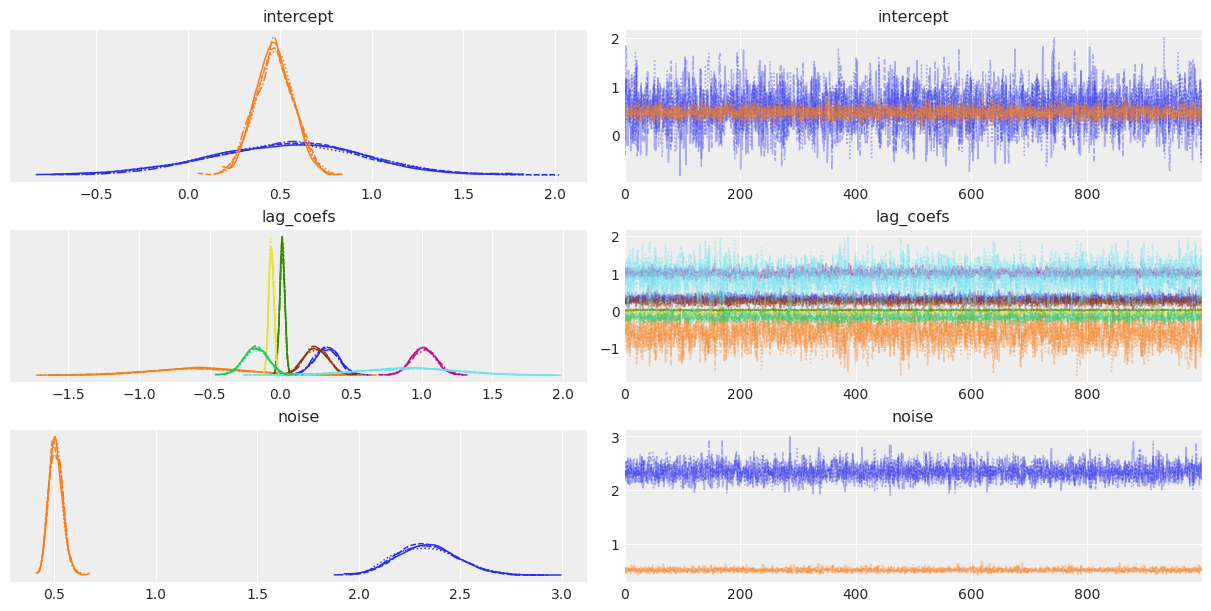

In [ ]:
az.plot_trace(trace);

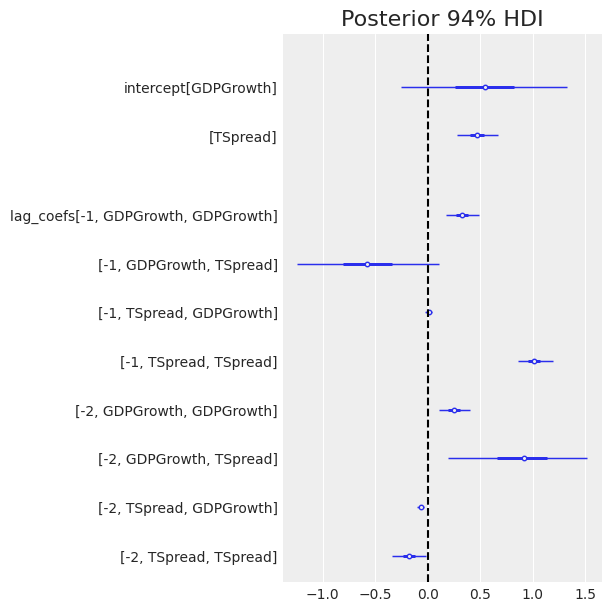

In [ ]:
az.plot_forest(trace, var_names=["intercept", "lag_coefs"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI");

In [ ]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=10):
    len_data = len(data)
    new_draws = np.zeros((data.shape[0]+forecast, data.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = data[:]
    for i in range(forecast):
        ar_GDPGrowth = np.sum(lag_coefs[:, 0] * new_draws[len_data+i-lags: len_data+i])
        ar_TSpread = np.sum(lag_coefs[:, 1] * new_draws[len_data+i-lags: len_data+i])
        mean = intercept + np.stack([ar_GDPGrowth, ar_TSpread])
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [ ]:
# Take a random subset of 100 draws from the posterior
draws = rng.integers(4000, size=100)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["intercept"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape

((100, 2), (100, 2, 2, 2), (100, 2))

In [ ]:
# Forecast 10 quarters into the future
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=10)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)

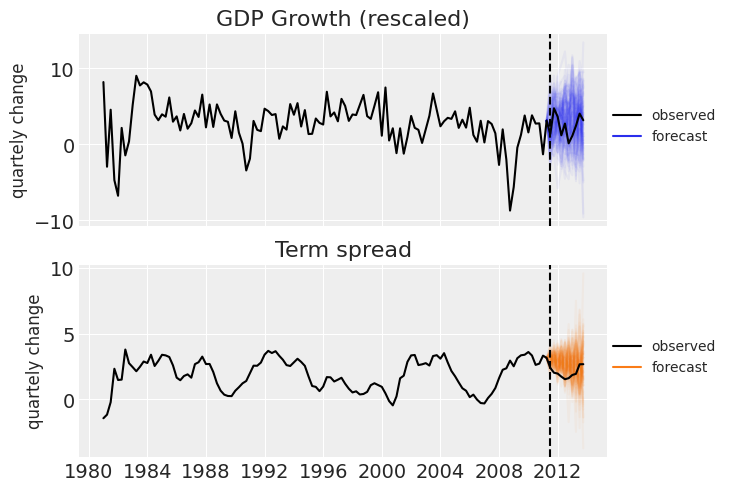

In [ ]:
_, ax = plt.subplots(2, 1, sharex=True)

ax[0].set_title("GDP Growth (rescaled)")
ax[0].plot(df.index, ppc_draws[..., 0], color="C0", alpha=0.05)
ax[0].plot(df["GDPGrowth"], color="k", label="observed")
ax[0].plot([], color="C0", label="forecast")

ax[1].set_title("Term spread")
ax[1].plot(df.index, ppc_draws[..., 1], color="C1", alpha=0.05)
ax[1].plot(df["TSpread"], color="k", label="observed")
ax[1].plot([], color="C1", label="forecast")

for axi in ax:
    axi.axvline(test_data.index[0], ls="--", color="k")
    axi.legend(fontsize=10, loc=(1, .4))
    axi.set_ylabel("quartely change", fontsize=12)

## BVAR for Iran data

In [4]:
MonthlyIDf = pd.read_excel(r'D:\Python_Project\VARModels\VARModels\raw\testdata.xlsx')
MonthlyIDf.index = pd.to_datetime(MonthlyIDf.date.apply(lambda x: jdatetime.date(int(x[:4]),int(x[5:7]),int(x[8:10])).togregorian()))

In [5]:
a = MonthlyIDf['2006-03-20':].drop(columns=['date','inf']).pct_change(periods=12)
YearlyIDf = a[a.index.month==3].dropna()

In [6]:
MonthlyIDf['MErGrowth'] = np.log(MonthlyIDf["er"] / MonthlyIDf["er"].shift())
MonthlyIDf['Mm2Growth'] = np.log(MonthlyIDf["m2"] / MonthlyIDf["m2"].shift())
MonthlyIDf['MmbGrowth'] = np.log(MonthlyIDf["mb"] / MonthlyIDf["mb"].shift())
MonthlyIDf['Mm1Growth'] = np.log(MonthlyIDf["m1"] / MonthlyIDf["m1"].shift())
MonthlyIDf['McpiGrowth'] = np.log(MonthlyIDf["cpi"] / MonthlyIDf["cpi"].shift())
MonthlyIDf.dropna(inplace=True)

In [7]:
IDf=MonthlyIDf
IDf

,date,m2,mb,m1,m2-m1,er,inf,cpi,MErGrowth,Mm2Growth,MmbGrowth,Mm1Growth,McpiGrowth
date,,,,,,,,,,,,,
2005-05-21,1384-02-31,682.42,145.92,230.25,452.16,8912.612903,0.146822,15.750150,0.003575,0.018009,0.000274,0.030560,-0.011763
2005-06-21,1384-03-31,704.59,150.99,239.10,465.49,8966.709677,0.146244,15.754760,0.006051,0.031971,0.034155,0.037716,0.000293
2005-07-22,1384-04-31,729.78,157.39,249.79,480.00,8990.419355,0.144279,15.974791,0.002641,0.035127,0.041513,0.043739,0.013869
2005-08-22,1384-05-31,767.27,167.42,261.54,505.73,8998.387097,0.141496,16.027920,0.000886,0.050096,0.061779,0.045967,0.003320
2005-09-22,1384-06-31,784.95,166.52,262.65,522.30,9013.935484,0.137645,16.068567,0.001726,0.022781,-0.005390,0.004235,0.002533
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-21,1401-03-31,51049.60,6403.70,11268.40,39781.20,317900.000000,0.389459,473.205370,0.217341,0.032145,-0.004425,0.109992,0.108962
2022-07-22,1401-04-31,52501.40,6530.30,11820.00,40681.40,319500.000000,0.400004,494.722410,0.005020,0.028042,0.019577,0.047791,0.044467
2022-08-22,1401-05-31,54017.90,6724.40,12163.10,41854.80,317500.000000,0.408980,504.797804,-0.006279,0.028476,0.029290,0.028614,0.020161


In [8]:
x = "MErGrowth"
y = "Mm2Growth"
z = "McpiGrowth"
Ilags = 2

In [9]:
Idata = IDf[[x, y, z]][:-10]
Itest_data = IDf[[x, y, z]][-10:]
Idata.shape, Itest_data.shape

((200, 3), (10, 3))

In [10]:
Icolors = ("C0", "C1", "C2")

Idark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
    "C2": tuple(c * .35 for c in (ColorConverter.to_rgb("C2")))
}

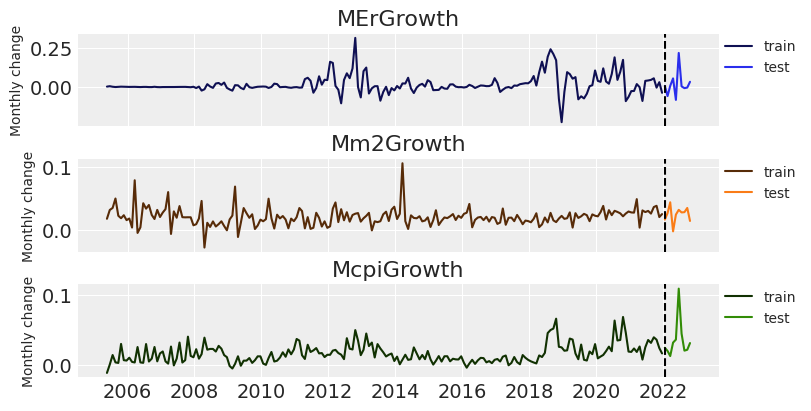

In [11]:
I_, Iax = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
Iax[0].plot(Idata[x], color=Idark["C0"], label="train")
Iax[0].plot(Itest_data[x], color="C0", label="test")
Iax[0].set_ylabel("Monthly change", fontsize=10)
Iax[0].set_title(x)

Iax[1].plot(Idata[y], color=Idark["C1"], label="train")
Iax[1].plot(Itest_data[y], color="C1", label="test")
Iax[1].set_ylabel("Monthly change", fontsize=10)
Iax[1].set_title(y);

Iax[2].plot(Idata[z], color=Idark["C2"], label="train")
Iax[2].plot(Itest_data[z], color="C2", label="test")
Iax[2].set_ylabel("Monthly change", fontsize=10)
Iax[2].set_title(z);

for Iaxi in Iax:
    Iaxi.axvline(IDf.index[-10], ls="--", color="k")
    Iaxi.legend(loc=(1, 0.5), fontsize=10)

In [12]:

Icoords={
    "lags": reversed(range(-Ilags, 0)),
    "vars": (x, y, z),
    "cross_vars": (x, y, z),
    "time": range(len(Idata) - Ilags),
}

with pm.Model(coords=Icoords) as IBVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars"))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_x = pm.math.sum([
        pm.math.sum(lag_coefs[i, 0] * Idata.values[Ilags-(i+1): -(i+1)], axis=-1)
        for i in range(Ilags)
    ], axis=0)        
    ar_y = pm.math.sum([
        pm.math.sum(lag_coefs[i, 1] * Idata.values[Ilags-(i+1): -(i+1)], axis=-1)
        for i in range(Ilags)
    ], axis=0)   

    ar_z = pm.math.sum([
        pm.math.sum(lag_coefs[i, 2] * Idata.values[Ilags-(i+1): -(i+1)], axis=-1)
        for i in range(Ilags)
    ], axis=0)   

    # Stack autoregressive terms and add intercepts
    mean = intercept + pm.math.stack([ar_x, ar_y, ar_z], axis=-1)

    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=Idata[Ilags:], dims=("time", "vars"))

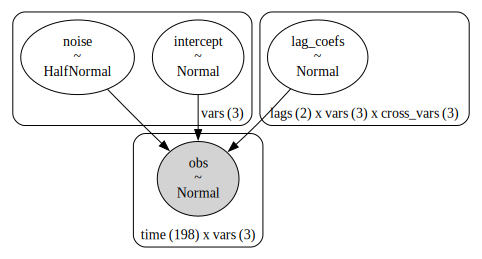

In [15]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

pm.model_to_graphviz(IBVAR_model)

In [16]:
with IBVAR_model:
    Itrace = pm.sample(draws=100 ,chains=4, random_seed=rng)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, lag_coefs, noise]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 1493 seconds.


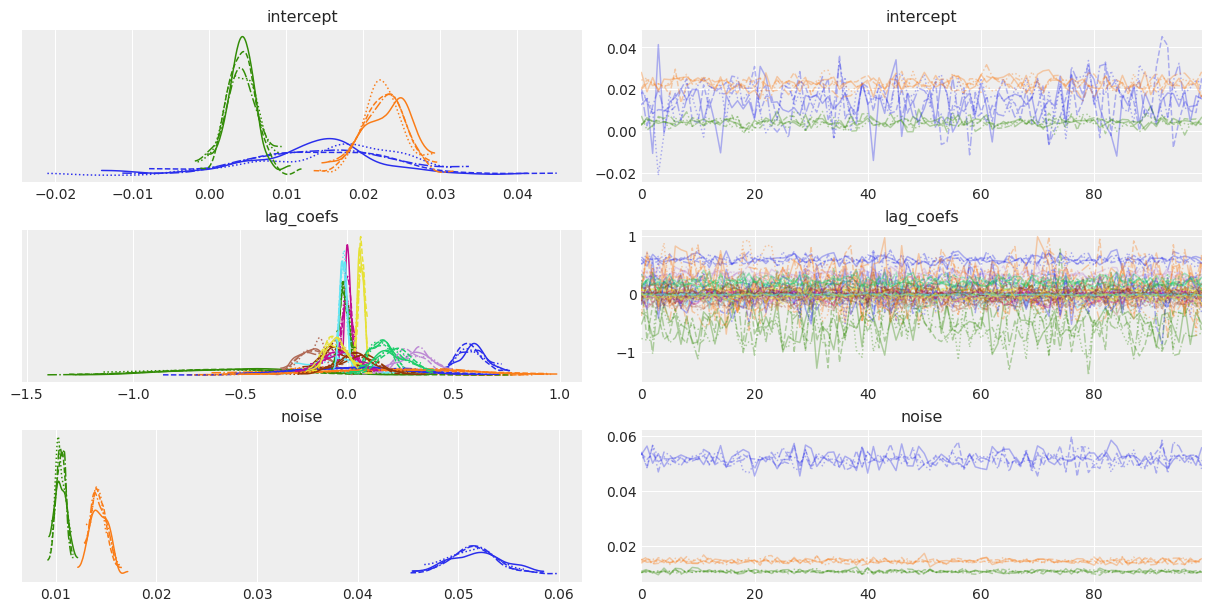

In [17]:
az.plot_trace(Itrace);

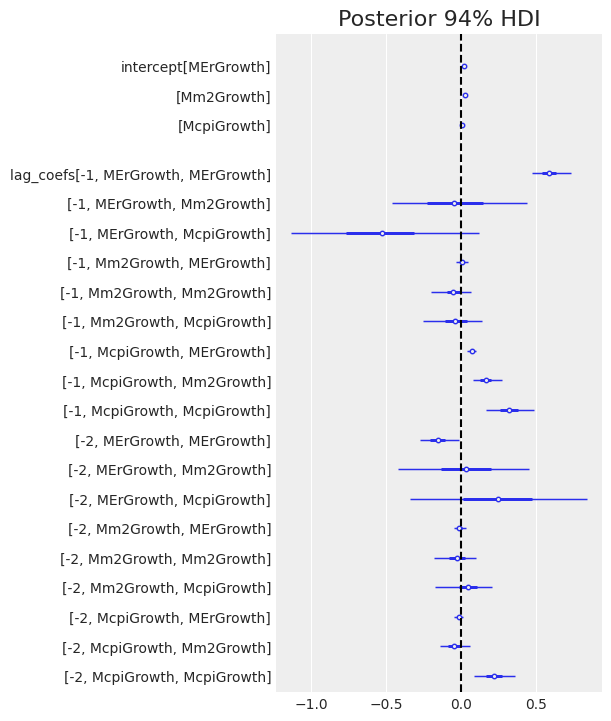

In [19]:
az.plot_forest(Itrace, var_names=["intercept", "lag_coefs"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI");

In [20]:
# Function that takes a single draw of parameters and forecasts n steps
def I_forecast(intercept, lag_coefs, noise, forecast=10):
    Ilen_data = len(Idata)
    Inew_draws = np.zeros((Idata.shape[0]+forecast, Idata.shape[1]))
    # Fill the new array with the observed data
    Inew_draws[:Ilen_data] = Idata[:]
    for i in range(forecast):
        ar_x = np.sum(lag_coefs[:, 0] * Inew_draws[Ilen_data+i-Ilags: Ilen_data+i])
        ar_y = np.sum(lag_coefs[:, 1] * Inew_draws[Ilen_data+i-Ilags: Ilen_data+i])
        ar_z = np.sum(lag_coefs[:, 2] * Inew_draws[Ilen_data+i-Ilags: Ilen_data+i])
        mean = intercept + np.stack([ar_x, ar_y,ar_z])
        Inew_draws[Ilen_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    Inew_draws[:-forecast-1] = np.nan
    return Inew_draws

# Vectorized forecast function to handle multiple parameter draws
Iforecast = np.vectorize(
    I_forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [21]:
# Take a random subset of 100 draws from the posterior
Idraws = rng.integers(400, size=100)

Ipost = Itrace.posterior.stack(sample=("chain", "draw"))
Iintercept_draws = Ipost["intercept"].values.T[Idraws]

Ilag_coefs_draws = Ipost["lag_coefs"].values.T[Idraws].T
Ilag_coefs_draws = np.moveaxis(Ilag_coefs_draws, -1, 0)

Inoise_draws = Ipost["noise"].values.T[Idraws]

Iintercept_draws.shape, Ilag_coefs_draws.shape, Inoise_draws.shape

((100, 3), (100, 2, 3, 3), (100, 3))

In [22]:
# Forecast 10 quarters into the future
Ippc_draws = Iforecast(Iintercept_draws, Ilag_coefs_draws, Inoise_draws, forecast=10)
Ippc_draws = np.swapaxes(Ippc_draws, 0, 1)

In [23]:
ForecastMean_x = np.zeros(Ippc_draws.shape[0])
for i in range(Ippc_draws.shape[0]):
    ForecastMean_x[i] = np.mean(Ippc_draws[i][:,0])

ForecastMean_y = np.zeros(Ippc_draws.shape[0])
for i in range(Ippc_draws.shape[0]):
    ForecastMean_y[i] = np.mean(Ippc_draws[i][:,1])

ForecastMean_z = np.zeros(Ippc_draws.shape[0])
for i in range(Ippc_draws.shape[0]):
    ForecastMean_z[i] = np.mean(Ippc_draws[i][:,2])

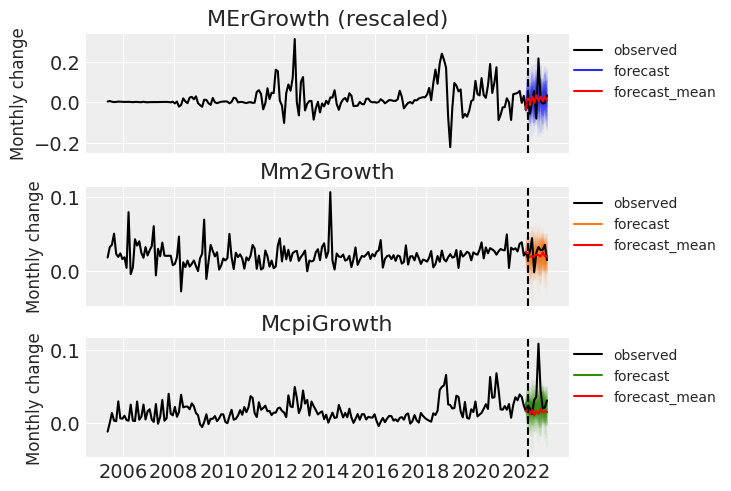

In [24]:
I_, Iax = plt.subplots(3, 1, sharex=True)

Iax[0].set_title(f"{x} (rescaled)")
Iax[0].plot(IDf.index, Ippc_draws[..., 0], color="C0", alpha=0.05)
Iax[0].plot(IDf[x], color="k", label="observed")
Iax[0].plot([], color="C0", label="forecast")
Iax[0].plot(IDf.index, ForecastMean_x, color="red", label="forecast_mean")

Iax[1].set_title(y)
Iax[1].plot(IDf.index, Ippc_draws[..., 1], color="C1", alpha=0.05)
Iax[1].plot(IDf[y], color="k", label="observed")
Iax[1].plot([], color="C1", label="forecast")
Iax[1].plot(IDf.index, ForecastMean_y, color="red", label="forecast_mean")

Iax[2].set_title(z)
Iax[2].plot(IDf.index, Ippc_draws[..., 1], color="C2", alpha=0.05)
Iax[2].plot(IDf[z], color="k", label="observed")
Iax[2].plot([], color="C2", label="forecast")
Iax[2].plot(IDf.index, ForecastMean_z, color="red", label="forecast_mean")

for axi in Iax:
    axi.axvline(Itest_data.index[0], ls="--", color="k")
    axi.legend(fontsize=10, loc=(1, .4))
    axi.set_ylabel("Monthly change", fontsize=12)

In [34]:
ForecastMean_z[-10:]

array([0.01990729, 0.01238837, 0.01781548, 0.01124027, 0.01631879,
       0.01290916, 0.0190716 , 0.01439949, 0.01611482, 0.01521733])

In [35]:
df = IDf[['MErGrowth', 'Mm2Growth', 'McpiGrowth']][-10:]

In [36]:
df['ForecastMeanMErGrowth'] =ForecastMean_x[-10:]
df['ForecastMeanMm2Growth'] = ForecastMean_y[-10:]
df['ForecastMeanMcpiGrowth'] = ForecastMean_z[-10:]

In [43]:
RMSFE_MErGrowth = np.sqrt(np.sum(np.power(df['MErGrowth']-df['ForecastMeanMErGrowth'],2)))
RMSFE_Mm2Growth = np.sqrt(np.sum(np.power(df['Mm2Growth']-df['ForecastMeanMm2Growth'],2)))
RMSFE_McpiGrowth = np.sqrt(np.sum(np.power(df['McpiGrowth']-df['ForecastMeanMcpiGrowth'],2)))

In [46]:
RMSFE = (RMSFE_MErGrowth,RMSFE_Mm2Growth,RMSFE_McpiGrowth)

In [50]:
df.to_excel(r'D:\Python_Project\VARModels\VARModels\Result\RMSFE.xlsx')